In [1]:
import math
import re
import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/theodoremui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier/notebooks'

In [3]:
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/collegier


In [4]:
import os
import boto3
import botocore
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
import sys
sys.path.append('src')
import ouraws

In [6]:
S3_BUCKET="collegier"
OUTPUT_DIR="data"
SCHOOL="berkeley"
SUBJECT="opinion"
START_YEAR=2011
FINAL_YEAR=2022

In [7]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N, 
            np.trace(cov)/N, 
            np.linalg.norm(cov, ord=1)/N, 
            np.linalg.norm(cov, ord=2)/N, 
            np.linalg.norm(cov, ord=np.inf)/N, 
            )

def cosine_distance(v1, v2):
    """Calculate the cosine distance between two numpy arrays.
    
    Parameters:
    a (numpy array): First input array.
    b (numpy array): Second input array.
    
    Returns:
    float: Cosine distance between a and b.
    """
    a = np.array(v1, dtype=np.float64)
    b = np.array(v2, dtype=np.float64)
    # Calculate dot product and magnitudes of the input arrays
    dot   = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    
    if np.isclose(a_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"a_mag is very small: {a_mag}")
    if np.isclose(b_mag, 0, rtol=1e-9, atol=1e-12):
        print(f"b_mag is very small: {b_mag}")
    
    # Calculate and return the cosine distance
    return 1.0 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
        # print(f"\tcos_distance: {measure(vec, v)}")
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    '''Normalize the dispersion by (N-Choose-2) number of pairs'''
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

In [8]:
diversity_words = [
    'diversity', 
    'equity',
    'inclusion',
    'inclusive',
    'inclusivity',
    'equality', 
    'equal opportunity',
    'social justice',
    'racial justice', 
    'multi-cultural', 
    'multicultural',
    'intercultural',
    'intersectional',
    'intersectionality',
    'anti-discrimination'
]
diversity_lemmas = [lemmatizer.lemmatize(w) for w in diversity_words]
diversity_lemmas

['diversity',
 'equity',
 'inclusion',
 'inclusive',
 'inclusivity',
 'equality',
 'equal opportunity',
 'social justice',
 'racial justice',
 'multi-cultural',
 'multicultural',
 'intercultural',
 'intersectional',
 'intersectionality',
 'anti-discrimination']

In [9]:
diversity_pattern = "\b" + "|".join(diversity_lemmas) + "\b"
text = "This is an inclusive and multi-cultural center that focuses on equality and racial justice."
len(re.findall(diversity_pattern, text))

4

In [10]:
english_stopwords = stopwords.words('english')
def prepText(text_series):
    '''Clean & prep text (numpy.Series): lowercase, lemmatize, stopword'''
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split() 
                           if w not in english_stopwords))
    text_series = text_series.apply(lambda x: x if len(x) > 100 else None)
    text_series = text_series.dropna()
    total_diversity_words = sum([len(re.findall(diversity_pattern, text)) 
                                 for text in text_series])
    return text_series, total_diversity_words

In [11]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [12]:
df.shape

(6095, 6)

In [13]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [14]:
df["year"].unique()

array([2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012,
       2011])

In [15]:
df.loc[(df.year==2011) & (df.month==5)]

,title,url,body,year,month,day
6083,A summer in the clouds,https://dailycal.org/2011/05/30/a-summer-in-th...,A summer in the clouds\nI’ve been trying to fo...,2011,5,30
6084,Bring in the green,https://dailycal.org/2011/05/30/bring-in-the-g...,Bring in the green\nIt is never good practice ...,2011,5,30
6085,No more hide and seek,https://dailycal.org/2011/05/30/no-more-hide-a...,No more hide and seek\nCalifornia’s public ins...,2011,5,30
6086,How to Keep Power ... and Keep It in Your Pants,https://dailycal.org/2011/05/26/how-to-keep-po...,How to Keep Power ... and Keep It in Your Pant...,2011,5,26
6087,OFF THE BEAT: Better re(a)d than dead,https://dailycal.org/2011/05/26/off-the-beat-b...,OFF THE BEAT: Better re(a)d than dead\nEssays ...,2011,5,26
6088,The empty gesture,https://dailycal.org/2011/05/22/the-empty-gesture,The empty gesture\nUC student Regent Jesse Che...,2011,5,22
6089,Get it together,https://dailycal.org/2011/05/22/get-it-together,Get it together\nThe UC Board of Regents’ unan...,2011,5,22
6090,OFF THE BEAT: Traveling sans language,https://dailycal.org/2011/05/22/off-the-beat-t...,OFF THE BEAT: Traveling sans language\nTraveli...,2011,5,22
6091,OFF THE BEAT: Sobering reflections of a grad,https://dailycal.org/2011/05/19/off-the-beat-s...,OFF THE BEAT: Sobering reflections of a grad\n...,2011,5,19
6092,"OFF THE BEAT: Apathy, the constant threat",https://dailycal.org/2011/05/15/off-the-beat-a...,"OFF THE BEAT: Apathy, the constant threat\n“Al...",2011,5,15


In [16]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    clean_df, num_diversity_words = prepText(year_df.body)    
    wv = [nlp(s) for s in clean_df]
        
    docmatrix = np.array([v.vector for v in wv])
    
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    cov = getCovDispersion(docmatrix)
    
    print(f"{year}, {cov[0]}, {cov[1]}, {pairwise}")
    
    result = {'year':     year,
              'pairwise': pairwise,
              'size':     cov[0],
              'trace':    cov[1],
              'norm-1':   cov[2], 
              'norm-2':   cov[3], 
              'norm-inf': cov[4], 
              'diversity-words': num_diversity_words,
              'mentions-norm'  : num_diversity_words/cov[0]
              }
    results.append(result)


2011, 345, 2.0395315232473497, 0.13385619041955926
2012, 528, 2.0349542165468932, 0.12272296881939224
2013, 550, 2.0382543728170233, 0.11459821425277994
2014, 493, 2.043043035525982, 0.09789561140431557
2015, 574, 2.1022375489278304, 0.1375908563981607
2016, 575, 2.053817837684051, 0.13373874528974117
2017, 589, 1.9965039957828459, 0.141407261182894
2018, 540, 2.059310284221314, 0.12533041758084595
2019, 487, 2.1399238529907074, 0.1193128226780263
2020, 507, 2.123809833692275, 0.11323440924474737
2021, 386, 2.0903468042586266, 0.11001768642705283
2022, 305, 2.0951182655975953, 0.1119346267076278


In [17]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2011,0.133856,345,2.039532,2.039245,1.757960,2.039245,50,0.144928
2012,0.122723,528,2.034954,2.069975,1.790042,2.069975,84,0.159091
2013,0.114598,550,2.038254,2.068997,1.803492,2.068997,193,0.350909
2014,0.097896,493,2.043043,2.120773,1.844494,2.120773,174,0.352941
2015,0.137591,574,2.102238,2.156391,1.813204,2.156391,184,0.320557
2016,0.133739,575,2.053818,2.048771,1.778594,2.048771,171,0.297391
2017,0.141407,589,1.996504,2.057212,1.720328,2.057212,224,0.380306
2018,0.125330,540,2.059310,2.123317,1.806492,2.123317,221,0.409259
2019,0.119313,487,2.139924,2.141641,1.880903,2.141641,295,0.605749


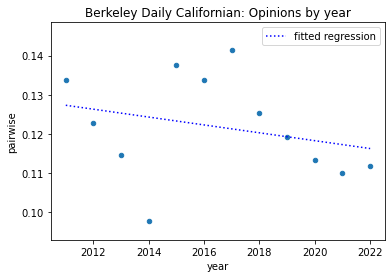

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Berkeley Daily Californian: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()


mentions-norm slope:0.03381, int:0.19607, r:0.76940, p:0.00343, se:0.00888, x:range(0, 12)
pairwise slope:-0.00100, int:0.12732, r:-0.27726, p:0.38295, se:0.00110, x:range(0, 12)
trace slope:0.00702, int:2.02947, r:0.60110, p:0.03871, se:0.00295, x:range(0, 12)
norm-1 slope:0.00354, int:2.07389, r:0.32542, p:0.30199, se:0.00325, x:range(0, 12)
norm-2 slope:0.00838, int:1.77029, r:0.59874, p:0.03969, se:0.00354, x:range(0, 12)
norm-inf slope:0.00354, int:2.07389, r:0.32542, p:0.30199, se:0.00325, x:range(0, 12)


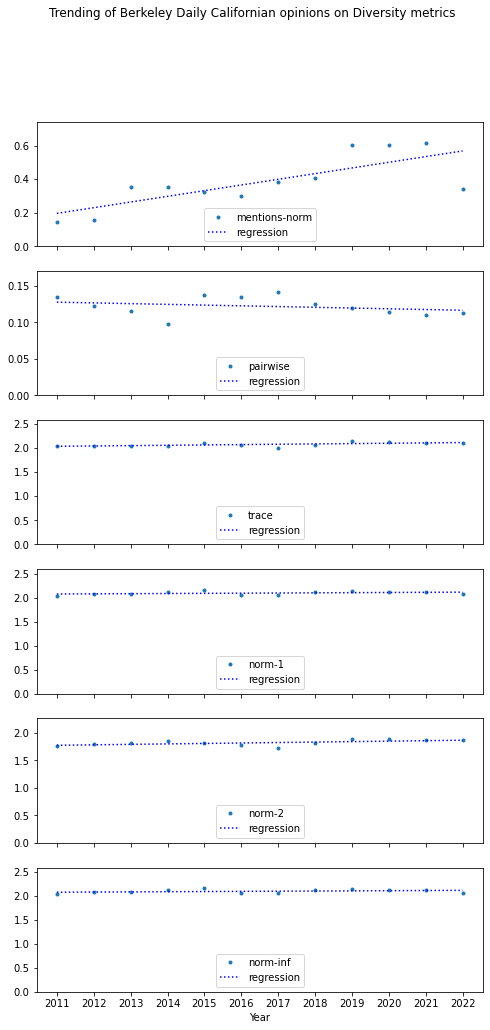

In [19]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=len(columns), ncols=1, sharex=True, figsize=(8,16))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Berkeley Daily Californian")
    
plt.xlabel("Year")
plt.suptitle("Trending of Berkeley Daily Californian opinions on Diversity metrics")
plt.show()

mentions-norm slope:0.03381, int:0.19607, r:0.76940, p:0.00343, se:0.00888, x:range(0, 12)
pairwise slope:-0.00100, int:0.12732, r:-0.27726, p:0.38295, se:0.00110, x:range(0, 12)


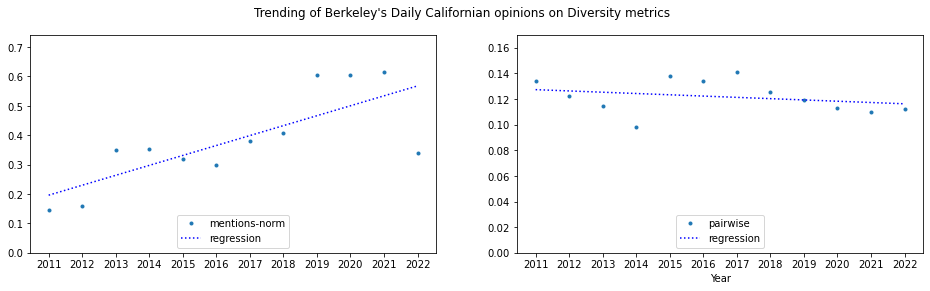

In [22]:
# Select the columns to plot
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16,4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]
     
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
            column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope*x, 'b:', label='regression')
    ax.set_ylim(0, max(y)*1.2)
    
    # Add a legend
    ax.legend(loc='lower center')

    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

    # Add a title
    # ax.set_title(f"Trending of {column} in Berkeley's Daily Californian")
    
plt.xlabel("Year")
plt.suptitle("Trending of Berkeley's Daily Californian opinions on Diversity metrics")
plt.show()